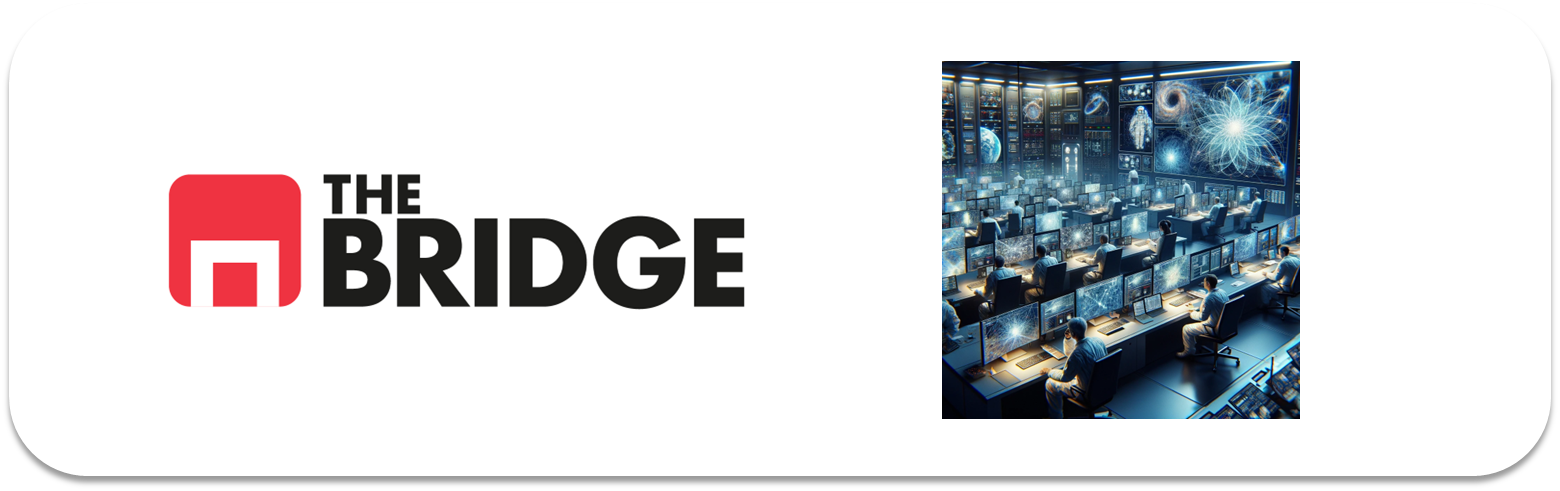

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [61]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import keras


from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



## 1. Preparación modelo (ejercicio unidad 1)

In [62]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [63]:
# Cargamos cada imagen y su etiqueta
X_train = []
y_train = []

for category in os.listdir(TRAIN_PATH):
    for file in os.listdir(os.path.join(TRAIN_PATH, category)):
        img = plt.imread(os.path.join(TRAIN_PATH, category, file))
        img = cv2.resize(img, (32, 32))
        X_train.append(img)
        y_train.append(category)

In [64]:
def read_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [65]:
X_train,y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH) # Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [66]:
y_train

array(['buildings', 'buildings', 'buildings', ..., 'street', 'street',
       'street'], dtype='<U9')

In [67]:
# comprobamos el tamaño de los datasets

print('X train shape: ', X_train.shape) # 14034 imágenes de 32 x 32 a color (3 canales)
print('Y train shape: ', y_train.shape)
print('X train shape: ', X_test.shape) # 3000 imágenes en test
print('Y train shape: ', y_test.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)
X train shape:  (3000, 32, 32, 3)
Y train shape:  (3000,)


In [68]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

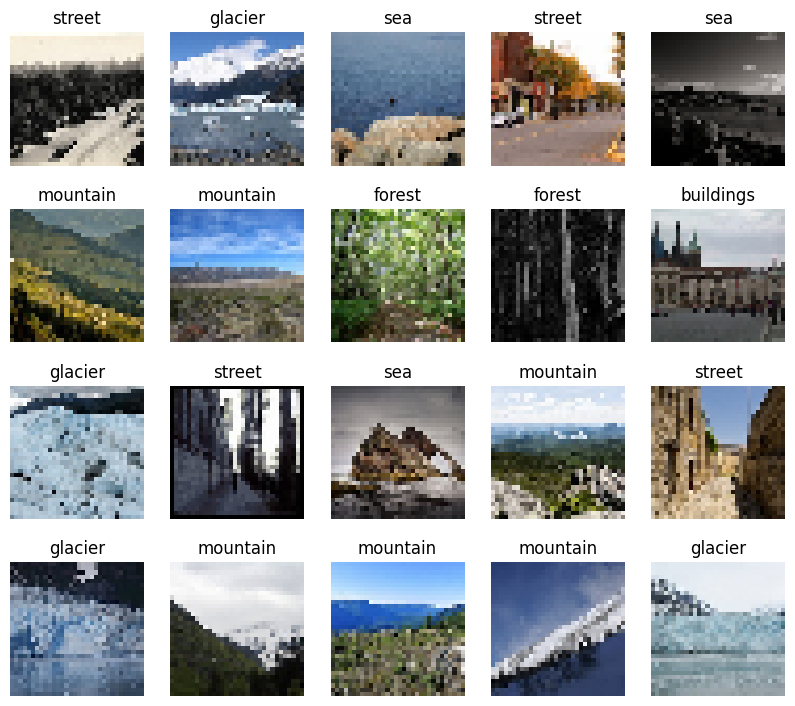

In [69]:
# pintamos alguna de las imágenes

indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [70]:
# mini-EDA --> distribución del target
# tenemos 6 clases cuya distribución es bastante balanceada

targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [71]:
# normalizamos
X_train = X_train/255
X_test = X_test/255

In [72]:
# diseñamos la topología de la red

# Primero definimos las capas de la red, en este caso partimos de 30 filtros de 3x3, seguido de una capa de pooling de 2x2,
# El input shape es el tamaño de las imágenes de entrada, en nuestro caso 32x32x3. 
# El tamaño del kernel es pequeño pero suele ser de este tipo y más con resoluciones tan bajas, el número de filtros está escogido de aquella manera,
# juega con el número de filtros.

capas = [keras.layers.Conv2D(filters = 30, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 15, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = 'relu'),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos dos capas densas para la clasificación 
         keras.layers.Dense(units = 150, activation = 'relu'),
         keras.layers.Dense(units = 100, activation = 'relu'),

# Añadimos la capa de salida con 6 neuronas, una por cada clase
         keras.layers.Dense(6, activation = 'softmax')]

# Creamos el modelo
model = keras.Sequential(capas)


In [73]:
# compilamos, dado el tampaño del train set usaremos un Adam  
# sparse categorical pues el target es unidimensional (es decir, no es un vector como el one-hot-encoding)
# escogempos la métrica accuracy pues los datos están equilibrados

print(X_train.size)

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

43112448


In [74]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 30)     │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │       144,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,761 (643.60 KB)

 Trainable params: 164,761 (643.60 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# mapeamos los valores del target para convertirlos en ordinales

mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # retomamos la serie 'targets' que utilizamos antes para ver su distribución
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [76]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [77]:
# por último, revolvemos los datos para que el modelo no aprenda el orden de las imágenes
X_train, y_train_num = shuffle(X_train, y_train_num)

Ya tenemos los datos preparados para el siguiente paso.

## 2. Transfer learning

In [111]:
# descargamos el modelo ResVet502 de keras además de 2 funciones con las que vamos a trabajar (decode_predictions y preprocess_input)
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

# y lo instanciamos
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [112]:
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [113]:
# Congelamos cada capa que comprende el modelo. Esto supone que aunque entrenemos el modelo, los pesos de las capas no van a cambiar
    
for layer in base_model.layers:
    layer.trainable = False   

In [114]:
x = layers.Flatten()(base_model.output) # capa flatten a la que le pasamos como input la salida (output) de nuestro modelo base 

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(300, activation='relu')(x)   # esa X va a una capa densa de 512 unidades /neuronas

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x) # añadimos una capa dropout ya que el modelo va a tener mucha profundidad

# Add a final sigmoid layer for classification
x = layers.Dense(len(mapa), activation='softmax')(x)  # capa densa de salida con tantas unidades (o neuronas) como clases tiene el target, para ello usamos nuestro dict de mapeado 

model = tf.keras.models.Model(base_model.input, x) # instanciamos un modelo donde la entrada es el input del base model y la salida es la x que hemos ido montando

# compilamos
model.compile(optimizer = 'adam',               
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [115]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,181,306 (92.24 MB)

 Trainable params: 616,506 (2.35 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [117]:
# Entrenamos el modelo

from time import time
t_zero = time()
history = model.fit(X_train, 
                    y_train_num,
                    batch_size = 64,
                    validation_split=0.2,
                    epochs=20,
                    callbacks= EarlyStopping(patience= 5, restore_best_weights= True))
print(time() - t_zero)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - acc: 0.6339 - loss: 0.9408 - val_acc: 0.5387 - val_loss: 1.2178
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - acc: 0.6575 - loss: 0.9012 - val_acc: 0.5358 - val_loss: 1.2323
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - acc: 0.6702 - loss: 0.8658 - val_acc: 0.5358 - val_loss: 1.2466
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - acc: 0.6851 - loss: 0.8283 - val_acc: 0.5326 - val_loss: 1.2582
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - acc: 0.6944 - loss: 0.8080 - val_acc: 0.5483 - val_loss: 1.2654
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - acc: 0.7128 - loss: 0.7825 - val_acc: 0.5401 - val_loss: 1.3034
138.36088943481445


<Axes: >

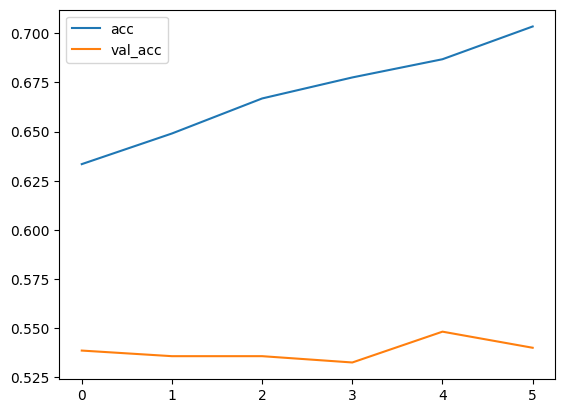

In [118]:
pd.DataFrame(history.history)[["acc","val_acc"]].plot()

<Axes: >

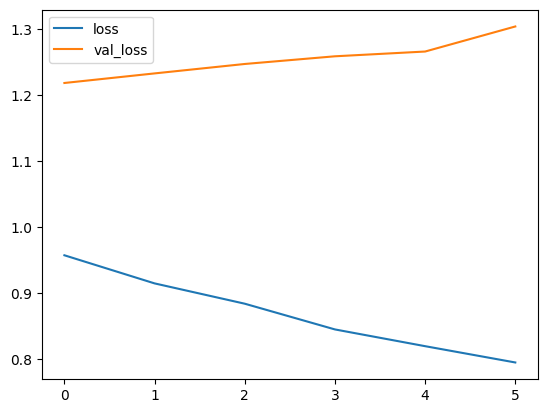

In [119]:
pd.DataFrame(history.history)[["loss","val_loss"]].plot()

In [120]:
# evaluamos el modelo

# Evaluamos el modelo
model.evaluate(X_test, y_test_num) # no obtenemos muy buenos resultados :(

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - acc: 0.5517 - loss: 1.2380


[1.190102219581604, 0.5583333373069763]

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       437
           1       0.70      0.76      0.73       474
           2       0.56      0.42      0.48       553
           3       0.49      0.62      0.54       525
           4       0.57      0.51      0.54       510
           5       0.52      0.57      0.54       501

    accuracy                           0.56      3000
   macro avg       0.56      0.56      0.56      3000
weighted avg       0.56      0.56      0.56      3000



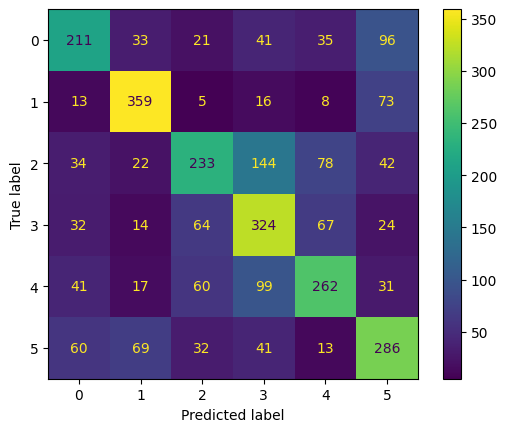

In [125]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [np.argmax(prediccion) for prediccion in model.predict(X_test)]
print(classification_report(y_test_num, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred);

In [126]:
# recordamos nuestras clases -->
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

Accuracy contra test es de apenas un 56%. La clase con más % de acierto es 1/ Forest con un 70% de precission y 76% de recall; le sigue la clase 3/mountain con un 62% de recall (en términos absolutos también es la clase que más acierta). Las clases 0/ buildings y 2/glacier son las que han obtenido peores resultados en métricas (recalls por debajo del 50% ). El modelo confunde buildings con street y glacier con mountain.  

## 3. Fine-tuning

In [128]:
# Cargamos el modelo pre-entrenado, pero esta vez SIN pesos 

base_model = ResNet50V2(include_top=False, weights=None, input_shape=(32, 32, 3))

In [129]:
x = layers.Flatten()(base_model.output) # capa flatten a la que le pasamos como input la salida (output) de nuestro modelo base 

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(300, activation='relu')(x)   # esa X va a una capa densa de 512 unidades /neuronas

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x) # añadimos una capa dropout ya que el modelo va a tener mucha profundidad

# Add a final sigmoid layer for classification
x = layers.Dense(len(mapa), activation='softmax')(x)  # capa densa de salida con tantas unidades (o neuronas) como clases tiene el target, para ello usamos nuestro dict de mapeado 

model = tf.keras.models.Model(base_model.input, x) # instanciamos un modelo donde la entrada es el input del base model y la salida es la x que hemos ido montando

# compilamos
model.compile(optimizer = 'adam',               
              loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])

In [130]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 24,181,306 (92.24 MB)

 Trainable params: 24,135,866 (92.07 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [131]:
# Entrenamos el modelo

from time import time
t_zero = time()
history = model.fit(X_train, 
                    y_train_num,
                    batch_size = 64,
                    validation_split=0.2,
                    epochs=20,
                    callbacks= EarlyStopping(patience= 5, restore_best_weights= True))
print(time() - t_zero)

Epoch 1/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 534ms/step - acc: 0.3958 - loss: 1.6421 - val_acc: 0.3388 - val_loss: 1.6025
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 104s 593ms/step - acc: 0.6292 - loss: 1.0114 - val_acc: 0.3890 - val_loss: 1.6080
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 114s 648ms/step - acc: 0.6898 - loss: 0.8765 - val_acc: 0.4115 - val_loss: 4.3299
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 112s 635ms/step - acc: 0.6978 - loss: 0.8478 - val_acc: 0.2861 - val_loss: 3.3929
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 597ms/step - acc: 0.6674 - loss: 0.8961 - val_acc: 0.4336 - val_loss: 2.3371
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 106s 601ms/step - acc: 0.7247 - loss: 0.7684 - val_acc: 0.5183 - val_loss: 1.5564
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 106s 604ms/step - acc: 0.7440 - loss: 0.7148 - val_acc: 0.3922 - val_loss: 2.6709
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 107s 607ms/step - acc: 0.7274 - loss: 0.7400 - val_acc: 0.5611 - val_loss: 1.3954
Epoch 9/20
176/176 ━━━━━

In [ ]:
# Evaluamos el modelo
model.evaluate(X_test, y_test_num) # obtenemos un 67% aprox de accuracy contra test

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - acc: 0.7709 - loss: 0.6723


[0.963141918182373, 0.6696666479110718]

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step
              precision    recall  f1-score   support

           0       0.57      0.78      0.66       437
           1       0.71      0.94      0.81       474
           2       0.69      0.66      0.68       553
           3       0.60      0.76      0.67       525
           4       0.86      0.34      0.49       510
           5       0.75      0.57      0.65       501

    accuracy                           0.67      3000
   macro avg       0.70      0.67      0.66      3000
weighted avg       0.70      0.67      0.66      3000



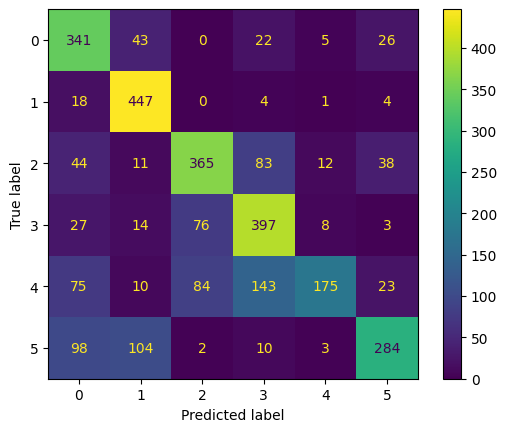

In [133]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

y_pred = [np.argmax(prediccion) for prediccion in model.predict(X_test)]
print(classification_report(y_test_num, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test_num, y_pred);

In [134]:
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

Hemos mejorado accuracy contra test a un 67% (11 puntos porcentuales con respecto al modelo de trasnfer learning). La clase con mayor acierto es la misma que en el modelo anterior: 1/forest con un 94% de recall y 81% de f-1 score. Le siguen la 0/buildings y la 2/glacier con 78 y 76% respectivamente en recall. En cuanto a las clases que el modelo a clasificado peor, tenemos en primer lugar la clase 4/sea con un 34% de recall y 46% de f1-score; la suele confundir cin la clase 3/ mountain (en la matriz de confusión vemos cómo ha clasificado 175 imágenes correctamente como 'sea', mientras que 143 han caído erróneamente en la clase 'mountain'). La siguiente clase peor clasificada es 5/street, el modelo la confunde con la clase 1/forest.

Este fue el resultado de la red convolucional del ejercicio de la unidad anterior:

*Hay un rectángulo interesante en el centro de la matriz, los glaciares (los paisajes peor detectados) se confunden principalmente con montañas, aunque estas se reconocen bastante bien. El mar también se confunde cuando lo hace con montañas. Esto hace que la precisión de las montañas baje. El mejor clasificado son los bosques seguido de las calles. Los edificios tampoco se clasifican bien y como era de esperar se confunden con las calles*


Comparativa:

Lo que todos tienen en común es que los bosques son la clase mejor clasificada; sin embargo, las calles no las clasifica bien. Montaña lo suele clasificar bien en general y tienen en común que glaciers se malinterpretan por éstas; buildings también es de las clases con peores métricas.